# U-Net

### Initial imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import keras
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Conv2DTranspose,
    BatchNormalization,
    Dense,
    Dropout,
)
from keras.models import Model
from keras.callbacks import EarlyStopping

### Loading images

In [2]:
# Dataset dependant parameters
data_path = "data/3ball/"
num_systems = 10000
num_balls = 3
pix = 32

X1 = []
for i in tqdm(glob(data_path + "Input/image1_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X1.append(im)
X1 = np.array(X1, dtype="float32") / 255

X2 = []
for i in tqdm(glob(data_path + "Input/image2_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X2.append(im)
X2 = np.array(X2, dtype="float32") / 255

Y = []
for i in tqdm(glob(data_path + "Output/*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    Y.append(im)
Y = np.array(Y, dtype="float32") / 255

100%|██████████| 10000/10000 [00:04<00:00, 2395.19it/s]


### Temperature computation and data split

In [3]:
coordinates = np.loadtxt(data_path + "coordinates.csv", delimiter=",")
coordinates = coordinates[:, -2 * num_balls :] / 4

temperature = np.zeros((num_systems))

for i in range(num_systems):
    for j in range(num_balls):
        # Add the speed of each ball to the temperature
        temperature[i] += np.sqrt(
            np.sum(np.square(coordinates[i, 2 * j : 2 * (j + 1)]))
        )

    # Divide by number of balls to get the mean
    temperature[i] /= num_balls

# Concatenate both frames
X = np.concatenate((X1, X2), axis=3)
# Train-val-test split (80-10-10)
x_train, x_test, y_train, y_test, temperature_train, temperature_test = (
    train_test_split(X, Y, temperature, test_size=0.2)
)
x_val, x_test, y_val, y_test, temperature_val, temperature_test = train_test_split(
    x_test, y_test, temperature_test, test_size=0.5
)

### Model definition and training

In [4]:
def double_conv_block(x, n_filters, drop_pct=0):
    # Conv2D then ReLU activation
    x = Conv2D(n_filters, (3, 3), activation="relu", padding="same")(x)
    # Dropout
    if drop_pct > 0:
        x = Dropout(drop_pct)(x)
    # Conv2D then ReLU activation
    x = Conv2D(n_filters, (3, 3), activation="relu", padding="same")(x)
    return x


def downsample_block(x, n_filters, drop_pct=0):
    f = double_conv_block(x, n_filters, drop_pct)
    p = MaxPooling2D((2, 2))(f)
    return f, p


def upsample_block(x, conv_features, n_filters, drop_pct=0):
    # upsample
    x = Conv2DTranspose(n_filters, (2, 2), (2, 2), padding="same")(x)
    # concatenate
    x = keras.layers.concatenate([x, conv_features])
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters, drop_pct)
    # batch normalization
    x = BatchNormalization()(x)
    return x


# Input layer
inputs = Input(shape=(pix, pix, 2))

# Encoder layers
f1, p1 = downsample_block(inputs, 8, drop_pct=0.1)
f2, p2 = downsample_block(p1, 16, drop_pct=0.1)
f3, p3 = downsample_block(p2, 32, drop_pct=0.2)
f4, p4 = downsample_block(p3, 64, drop_pct=0.2)

# Bottleneck layer
bottleneck = double_conv_block(p4, 128, drop_pct=0.3)

# Decoder layers
u6 = upsample_block(bottleneck, f4, 64, drop_pct=0.2)
u7 = upsample_block(u6, f3, 32, drop_pct=0.2)
u8 = upsample_block(u7, f2, 16, drop_pct=0.1)
u9 = upsample_block(u8, f1, 8, drop_pct=0.1)

# Output layer
outputs = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(u9)

unet_model = Model(inputs, outputs, name="U-Net")
unet_model.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 2)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 8)    152         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 32, 32, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 8)    584         ['dropout[0][0]']                
                                                                                              

In [5]:
unet_model.compile(optimizer="adam", loss="mse")

unet_model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=[
        EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True, min_delta=0.001
        )
    ],
)

Epoch 1/100
250/250 [==============================] - 54s 172ms/step - loss: 0.1237 - val_loss: 0.0306
Epoch 2/100
250/250 [==============================] - 44s 177ms/step - loss: 0.0535 - val_loss: 0.0476
Epoch 3/100
250/250 [==============================] - 47s 189ms/step - loss: 0.0464 - val_loss: 0.0451
Epoch 4/100
250/250 [==============================] - 42s 169ms/step - loss: 0.0369 - val_loss: 0.0172
Epoch 5/100
250/250 [==============================] - 38s 154ms/step - loss: 0.0134 - val_loss: 0.0120
Epoch 6/100
250/250 [==============================] - 41s 164ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 7/100
250/250 [==============================] - 44s 176ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 8/100
250/250 [==============================] - 53s 212ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 9/100
250/250 [==============================] - 42s 169ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 10/100
250/250 [==============================] - 43s 172m

### Model reconstructions

We print (from left to right) the 3 frames of the sample (2 inputs and output), an auxiliar image to see of how much movement there is between the first and final frame, the reconstructed image and the 3rd frame over the reconstructed image. This last image is useful to see if the position of the balls is accurately predicted.

32/32 [==============================] - 2s 34ms/step


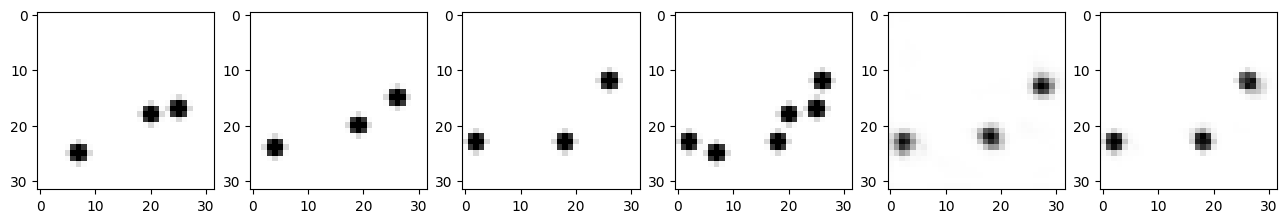

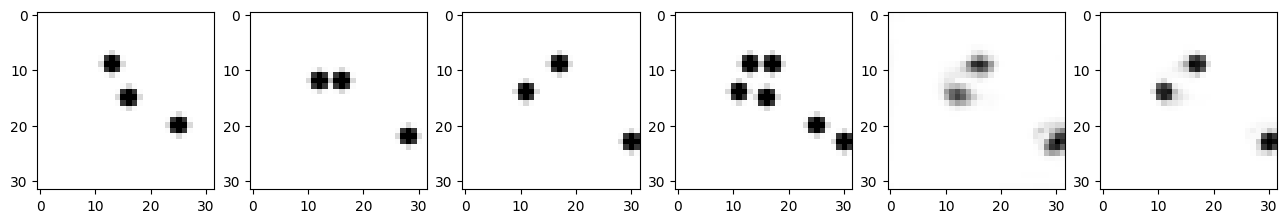

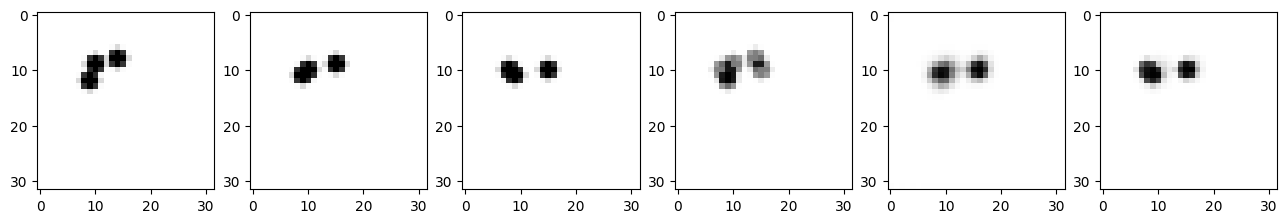

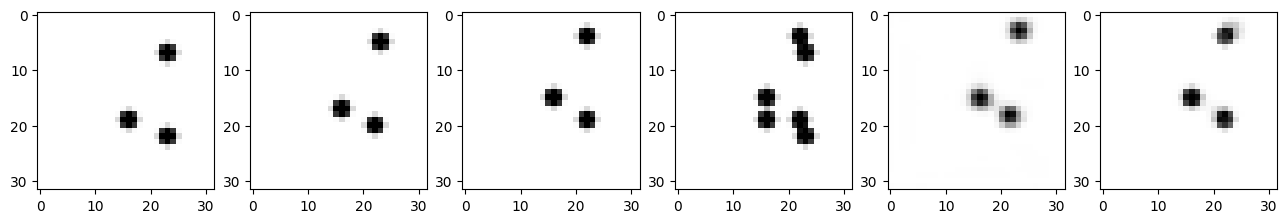

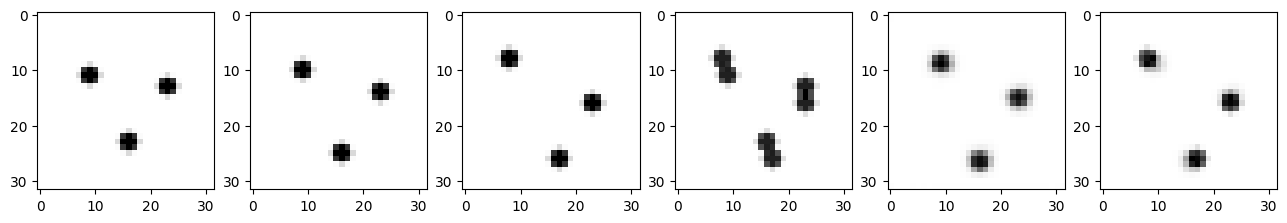

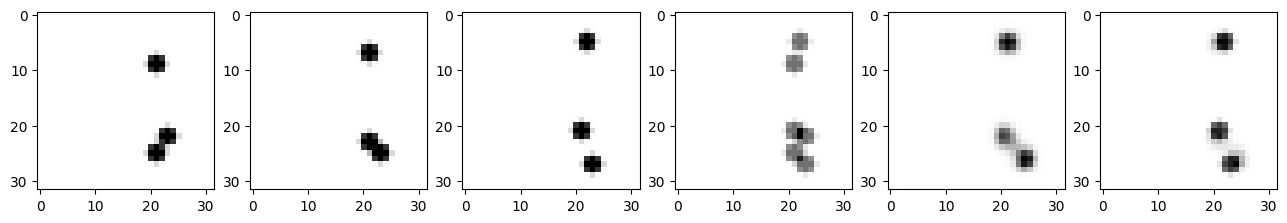

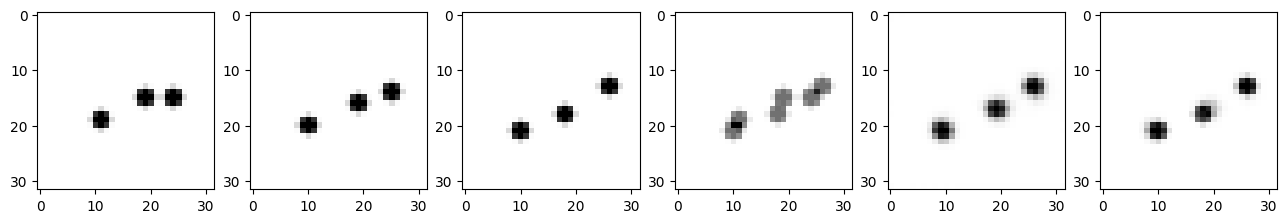

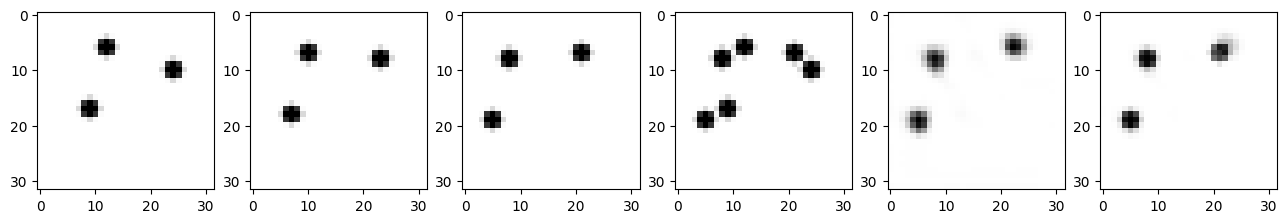

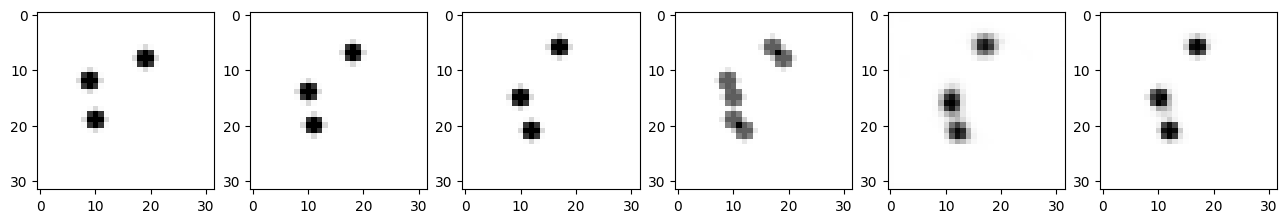

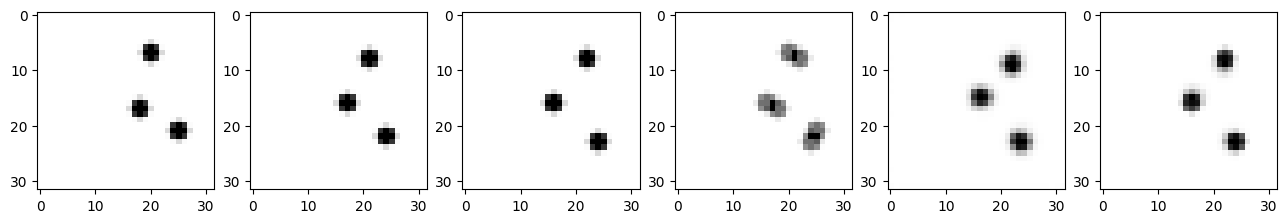

In [6]:
predictions = unet_model.predict(x_test)

for i in range(10):
    plt.figure(figsize=(16, 96))
    # First image
    plt.subplot(1, 6, 1)
    plt.imshow(x_test[i, :, :, 0].reshape(pix, pix), cmap="gray")

    # Second image
    plt.subplot(1, 6, 2)
    plt.imshow(x_test[i, :, :, 1].reshape(pix, pix), cmap="gray")

    # Third image
    plt.subplot(1, 6, 3)
    plt.imshow(y_test[i].reshape(pix, pix), cmap="gray")

    # Balls in first and final frame to check how much movement there is on that sample
    plt.subplot(1, 6, 4)
    plt.imshow(
        y_test[i].reshape(pix, pix) + x_test[i, :, :, 0].reshape(pix, pix), cmap="gray"
    )

    # Predicted image
    plt.subplot(1, 6, 5)
    plt.imshow(predictions[i].reshape(pix, pix), cmap="gray")

    # Image to predict over reconstruction
    plt.subplot(1, 6, 6)
    plt.imshow(
        y_test[i].reshape(pix, pix) + predictions[i].reshape(pix, pix) / 2, cmap="gray"
    )

    plt.show()

### Temperature regression

We will try to regress the temperature of the system with the activation weights of the last concatenation layer (it should have all the information from the skip connections and the downsample and umpsample path).

In [7]:
last_layer = Model(
    inputs=unet_model.input, outputs=unet_model.get_layer("concatenate_3").output
)

# Get the encoded representation of the images in train, validation and test sets
encoded_imgs_train = last_layer.predict(x_train)
encoded_imgs_val = last_layer.predict(x_val)
encoded_imgs_test = last_layer.predict(x_test)

# Reshape to vectors (flatten)
encoded_imgs_train_flat = encoded_imgs_train.reshape((encoded_imgs_train.shape[0], -1))
encoded_imgs_val_flat = encoded_imgs_val.reshape((encoded_imgs_val.shape[0], -1))
encoded_imgs_test_flat = encoded_imgs_test.reshape((encoded_imgs_test.shape[0], -1))

32/32 [==============================] - 1s 18ms/step


Let us try with a linear regression with just the activation weights.

In [8]:
temperature_regressor_1 = LinearRegression()
temperature_regressor_1.fit(encoded_imgs_train_flat, temperature_train)
score = mean_squared_error(
    temperature_val, temperature_regressor_1.predict(encoded_imgs_val_flat)
)
print("MSE: " + str(score))

temperature_predictions = temperature_regressor_1.predict(encoded_imgs_test_flat)

for i in range(5):
    print(
        "Sample "
        + str(i)
        + "\nPrediction: "
        + str(temperature_predictions[i])
        + "\nActual temperature: "
        + str(temperature_test[i])
    )

MSE: 10.43073357014538
Sample 0
Prediction: -33.07373
Actual temperature: 0.6165288031390141
Sample 1
Prediction: -0.18151855
Actual temperature: 0.7492253987428809
Sample 2
Prediction: 0.60876465
Actual temperature: 0.16666666666666666
Sample 3
Prediction: 0.45214844
Actual temperature: 0.3678511301977579
Sample 4
Prediction: 0.2756958
Actual temperature: 0.45118446353109126


Next, we try applying a convolutional layer and a fully-connected network.

In [9]:
inputs = Input(shape=(pix, pix, 16))

x = Conv2D(1, (3, 3), activation="relu")(inputs)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(16, activation="relu")(x)

outputs = Dense(1, activation="sigmoid")(x)

temperature_regressor_2 = Model(inputs, outputs, name="ConvAndFC")

temperature_regressor_2.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "ConvAndFC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 16)]      0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 1)         145       
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                                                 
 dense (Dense)               (None, 128)               115328    
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 117,554
Trainable params: 117,554
Non-train

In [10]:
temperature_regressor_2.compile(optimizer="adam", loss="mse")

temperature_regressor_2.fit(
    encoded_imgs_train,
    temperature_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(encoded_imgs_val, temperature_val),
    callbacks=[
        EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True, min_delta=0.001
        )
    ],
)

Epoch 1/100
250/250 [==============================] - 10s 31ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 2/100
250/250 [==============================] - 6s 26ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 3/100
250/250 [==============================] - 5s 21ms/step - loss: 0.0080 - val_loss: 0.0094
Epoch 4/100
250/250 [==============================] - 7s 30ms/step - loss: 0.0077 - val_loss: 0.0085
Epoch 5/100
250/250 [==============================] - 7s 26ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 6/100
250/250 [==============================] - 6s 25ms/step - loss: 0.0072 - val_loss: 0.0088


In [11]:
temperature_predictions = temperature_regressor_2.predict(encoded_imgs_test)

for i in range(5):
    print(
        "Sample "
        + str(i)
        + "\nPrediction: "
        + str(temperature_predictions[i])
        + "\nActual temperature: "
        + str(temperature_test[i])
    )

32/32 [==============================] - 0s 6ms/step
Sample 0
Prediction: [0.58604324]
Actual temperature: 0.6165288031390141
Sample 1
Prediction: [0.7336272]
Actual temperature: 0.7492253987428809
Sample 2
Prediction: [0.31073654]
Actual temperature: 0.16666666666666666
Sample 3
Prediction: [0.48925507]
Actual temperature: 0.3678511301977579
Sample 4
Prediction: [0.33366647]
Actual temperature: 0.45118446353109126


Lastly, we try with only a fully-connected network with no extra convolutional layers.

In [12]:
inputs = Input(shape=(pix * pix * 16))

x = Dense(128, activation="relu")(inputs)
x = Dense(16, activation="relu")(x)
x = Dropout(0.3)(x)

outputs = Dense(1, activation="sigmoid")(x)

temperature_regressor_3 = Model(inputs, outputs, name="FC")

temperature_regressor_3.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16384)]           0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,099,361
Trainable params: 2,099,361
Non-trainable params: 0
_________________________________________________________________


In [13]:
temperature_regressor_3.compile(optimizer="adam", loss="mse")

temperature_regressor_3.fit(
    encoded_imgs_train_flat,
    temperature_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(encoded_imgs_val_flat, temperature_val),
    callbacks=[
        EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True, min_delta=0.001
        )
    ],
)

Epoch 1/100
250/250 [==============================] - 17s 63ms/step - loss: 0.0174 - val_loss: 0.0093
Epoch 2/100
250/250 [==============================] - 14s 55ms/step - loss: 0.0132 - val_loss: 0.0101
Epoch 3/100
250/250 [==============================] - 13s 52ms/step - loss: 0.0128 - val_loss: 0.0088
Epoch 4/100
250/250 [==============================] - 12s 50ms/step - loss: 0.0129 - val_loss: 0.0086
Epoch 5/100
250/250 [==============================] - 13s 54ms/step - loss: 0.0130 - val_loss: 0.0093
Epoch 6/100
250/250 [==============================] - 13s 50ms/step - loss: 0.0130 - val_loss: 0.0092


In [14]:
temperature_predictions = temperature_regressor_3.predict(encoded_imgs_test_flat)

for i in range(5):
    print(
        "Sample "
        + str(i)
        + "\nPrediction: "
        + str(temperature_predictions[i])
        + "\nActual temperature: "
        + str(temperature_test[i])
    )

32/32 [==============================] - 0s 9ms/step
Sample 0
Prediction: [0.59511846]
Actual temperature: 0.6165288031390141
Sample 1
Prediction: [0.70048004]
Actual temperature: 0.7492253987428809
Sample 2
Prediction: [0.34254164]
Actual temperature: 0.16666666666666666
Sample 3
Prediction: [0.50666255]
Actual temperature: 0.3678511301977579
Sample 4
Prediction: [0.3534302]
Actual temperature: 0.45118446353109126
